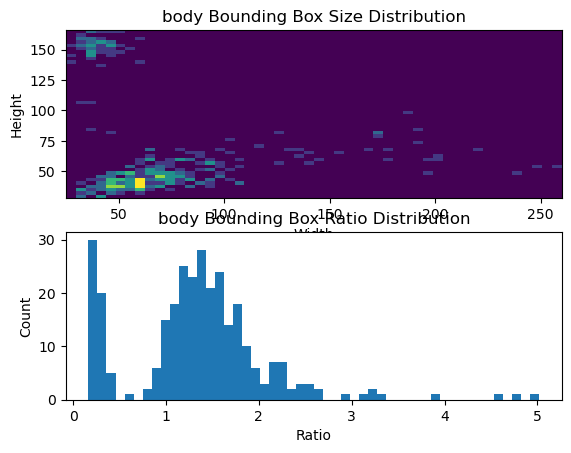

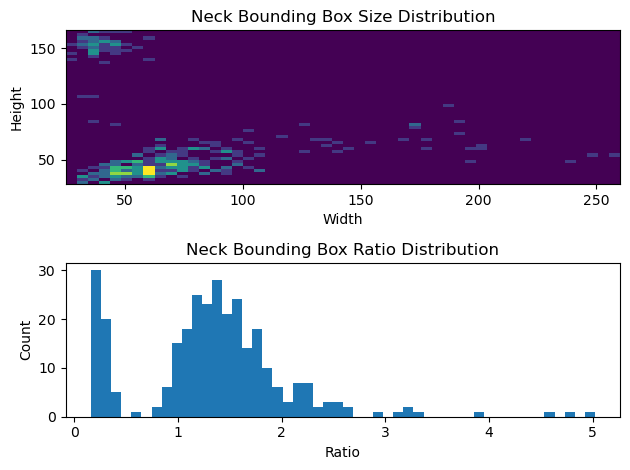

Average size of body: [60.98631132 72.23606725]
Standard deviation of sizes of body: [58.96924278 76.99148763]
Average ratio of body: 0.9708539696126657
Standard deviation of ratios of body: 0.4882245714576233
Average size of Neck: [69.83045387 66.17293102]
Standard deviation of sizes of Neck: [39.31459372 41.44328242]
Average ratio of Neck: 1.3415962436069326
Standard deviation of ratios of Neck: 0.7416197444962972


In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

root_dir = "/dev/URP/Plastic_Bottle_defect_detection/data/"
categories = ["body", "Neck"]

bbox_sizes_dict = {category: [] for category in categories}
bbox_ratios_dict = {category: [] for category in categories}

for category in categories:
    image_dir = os.path.join(root_dir, category, "image")
    label_dir = os.path.join(root_dir, category, "label")

    for file_name in os.listdir(label_dir):
        if not file_name.endswith(".txt"):
            continue

        label_path = os.path.join(label_dir, file_name)
        image_path = os.path.join(image_dir, file_name.replace(".txt", ".jpg"))

        # 이미지 크기 가져오기
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()

                # 바운딩 박스 좌표 읽어오기
                class_id, x_center_rel, y_center_rel, width_rel, height_rel= map(float ,parts)

                # 절대적인 바운딩 박스 크기 계산하기
                bbox_width_abs  = width_rel * img_width
                bbox_height_abs  = height_rel * img_height
                
                bbox_size_abs  =(bbox_width_abs,bbox_height_abs)

                #바운딩박스 사이즈 리스트에 추가하기 
                bbox_sizes_dict[category].append(bbox_size_abs)
                
                 #바운딩박스 비율 리스트에 추가하기 
                bbox_ratios_dict[category].append(bbox_width_abs/bbox_height_abs)


# 분포 계산 (numpy 활용)
average_size_dict={}
std_size_dict={}
average_ratio_dict={}
std_ratio_dict={}

for category in categories:

    bbox_sizes_np=np.array(bbox_sizes_dict[category])
    bbox_ratios_np=np.array(bbox_ratios_dict[category])

    average_size=np.mean(bbox_sizes_np,axis=0)
    std_size=np.std(bbox_sizes_np,axis=0)

    average_ratio=np.mean(bbox_ratios_np)
    std_ratio=np.std(bbox_ratios_np)

    
    average_size_dict[category]=average_size
    std_size_dict[category]=std_size
    
    average_ratio_dict[category]=average_ratio
    std_ratio_dict[category]=std_ratio


# 그래프 그리기 (각 카테고리 별로 따로 그림)
for i_category , category in enumerate(categories):
    
   
   fig , axs=plt.subplots(2) 

   axs[0].hist2d(x=bbox_sizes_np[:, 0], y=bbox_sizes_np[:, 1], bins=50)
   axs[0].set_xlabel('Width')
   axs[0].set_ylabel('Height')
   axs[0].set_title(f'{category} Bounding Box Size Distribution')

   # 바운딩 박스 비율 분포 그래프
   axs[1].hist(bbox_ratios_np.flatten(), bins=50)
   axs[1].set_xlabel('Ratio')
   axs[1].set_ylabel('Count')
   axs[1].set_title(f'{category} Bounding Box Ratio Distribution')

   
   
   
plt.tight_layout()
plt.show()

for category in categories:
    print(f'Average size of {category}: {average_size_dict[category]}')
    print(f'Standard deviation of sizes of {category}: {std_size_dict[category]}')
    print(f'Average ratio of {category}: {average_ratio_dict[category]}')
    print(f'Standard deviation of ratios of {category}: {std_ratio_dict[category]}')

In [21]:
import os
import cv2
import numpy as np
import pandas as pd

# 이미지와 레이블 경로 설정
root_dir = "/dev/URP/Plastic_Bottle_defect_detection/data/"
img_dir = os.path.join(root_dir,"body/image")
label_dir = os.path.join(root_dir,"body/label")
# categories = ["body", "Neck"]

# 데이터 저장을 위한 리스트 초기화
class_id_list = []
bbox_width_list = []
bbox_height_list = []
bbox_x_center_list = []
bbox_y_center_list = []

# 모든 이미지 파일에 대해 반복
for filename in os.listdir(img_dir):
    # 이미지 읽기 (흑백으로 읽음)
    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # 레이블 파일 이름 생성 및 열기
    label_filename = filename.replace('.jpg', '.txt')
    label_path = os.path.join(label_dir, label_filename)

    if not os.path.exists(label_path):
        continue

    with open(label_path) as f:
        for line in f:
            # 공백으로 분리된 값을 리스트로 변환 
            class_id, x_center_norm, y_center_norm, width_norm, height_norm  = map(float,line.split())

            # 클래스 ID와 바운딩 박스 크기 추가 (실제 크기는 정규화된 값에 이미지 너비/높이를 곱함)
            class_id_list.append(class_id)
            bbox_width_list.append(width_norm * img.shape[1])
            bbox_height_list.append(height_norm * img.shape[0])
            bbox_x_center_list.append(x_center_norm * img.shape[1])
            bbox_y_center_list.append(y_center_norm * img.shape[0])

# DataFrame 생성 
df_bbox_info_body= pd.DataFrame({'class_id': class_id_list,
                                 'width': bbox_width_list,
                                 'height': bbox_height_list,
                                 'x_center': bbox_x_center_list,
                                 'y_center': bbox_y_center_list})

print(df_bbox_info_body.head())

for class_id in df_bbox_info_body['class_id'].unique():
    df_class_i= df_bbox_info_body[df_bbox_info_body['class_id'] == class_id]

    print(f"Class {int(class_id)}:")
    print(f"  Bounding box size (width, height) mean: ({df_class_i['width'].mean()}, {df_class_i['height'].mean()})")
    print(f"  Bounding box size (width, height) variance: ({df_class_i['width'].var()}, {df_class_i['height'].var()})")
    print(f"  Bounding box center location (x, y) mean: ({df_class_i['x_center'].mean()}, {df_class_i['y_center'].mean()})")
    print()

   class_id  width  height  x_center  y_center
0       1.0   98.0    98.0     932.5    1219.5
1       0.0   32.0    35.0    1481.0     663.5
2       0.0   32.0    39.0    1286.5     196.5
3       1.0   41.0   202.0      39.5    1319.5
4       0.0   33.0    35.0    1193.0     177.5
Class 1:
  Bounding box size (width, height) mean: (87.06439950107065, 105.4152164882227)
  Bounding box size (width, height) variance: (4812.190289327637, 7488.53408010195)
  Bounding box center location (x, y) mean: (750.3408043276231, 823.5188391691647)

Class 0:
  Bounding box size (width, height) mean: (29.93042672704715, 31.31864901736973)
  Bounding box size (width, height) variance: (112.44349793729137, 102.02490004550188)
  Bounding box center location (x, y) mean: (718.9508865434243, 702.1479334516127)

Class 2:
  Bounding box size (width, height) mean: (145.24988825000003, 321.00028125)
  Bounding box size (width, height) variance: (5622.2261359931545, 71259.47577088205)
  Bounding box center locat